# Impact of infix vs. prefix notation on working memory

This experiment evaluates the impact of infix vs. prefix notation in performing mental arithmetic. The participant is repeatedly provided infix expressions without parentheses like:

```
1 + 2 * 4 - 3
```

And equivalent prefix expressions like:

```
(- (+ 1 (* 2 4)) 3)
```

Like last experiment, the participant is asked to mentally compute each expressions. The condition is the number of operations in the expression, here 4 and 8. 

**Hypothesis:** when going from 4 to 8 operations, the average duration should be proportionately higher for prefix than infix due to increased working memory load of tracking computation intermediates.

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Method

The experimental UI is below.

In [380]:
from IPython.core.display import display, HTML, clear_output
from code_diff import Code
import ipywidgets as widgets
from timeit import default_timer as now
import random
from random import choice, randint
import ast
import showast
import astor
import pandas as pd
from scipy.stats import f_oneway
from utils import variable_test, fix_test
import seaborn as sns
import matplotlib.pyplot as plt
a2s = astor.to_source

In [121]:
class Expr:
    def __init__(self, assignments, expr, params):
        self.assignments = assignments
        self.expr = expr
        self.params = params
        
    def to_string(self):
        return '\n'.join(self.assignments), ' '.join(self.expr)[:-1]
    
    def _to_infix(self, node):
        if isinstance(node, ast.BinOp):
            op = node.op
            op_str = None
            if isinstance(op, ast.Add):
                op_str = '+'
            elif isinstance(op, ast.Sub):
                op_str = '-'
            elif isinstance(op, ast.Mult):
                op_str = '*'                
            (l, r) = self._to_infix(node.left), self._to_infix(node.right)
            return f'({op_str} {l} {r})'
        elif isinstance(node, ast.Num):
            return node.n
    
    def to_string_infix(self):
        ctx, expr = self.to_string()
        expr_infix = self._to_infix(ast.parse(expr).body[0].value)
        return ctx, expr_infix
    
    def eval_expr(self):
        ctx, expr = self.to_string()
        ctx2 = '\n\t'.join(ctx.split('\n'))
        exec(f'def p():\n\t{ctx2}\n\treturn {expr}\nret = p()', globals())
        return ret 

In [297]:
class ExprGenerator:
    def __init__(self, cnst_count, vr_count):
        self.vrs = ['x', 'y', 'z', 'w', 'k', 'n', 'a']
        self.cnst_count = cnst_count
        self.vr_count = vr_count
        self.ops = ['+', '-', '*']
        
    def gen(self, distinct_vrs):
        random.shuffle(self.vrs)
        vrs = self.vrs[:distinct_vrs]
        vr_assgn = [f'{vr} = {randint(1, 8)}' for vr in vrs]        
        assert self.vr_count >= distinct_vrs
        values = vrs + [choice(vrs) for _ in range(self.vr_count - distinct_vrs)] \
            + [randint(1, 3) for _ in range(self.cnst_count)]
        random.shuffle(values)
        expr = [f'{v} {choice(self.ops)}' for v in values]
        assign_str = '\n'.join(vr_assgn)
        expr_str = ' '.join(expr)[:-1]
        return Expr(vr_assgn, expr, 
                    {'cnst_count': self.cnst_count, 'vr_count': self.vr_count, 'distinct_vrs': distinct_vrs})        

In [311]:
expr = ExprGenerator(cnst_count=4, vr_count=0).gen(distinct_vrs=0)
print(expr.to_string_infix()[1])
print(expr.to_string()[1])

(- (+ (* 3 3) 2) 1)
3 * 3 + 2 - 1 


In [312]:
fourop_infix_results = []

In [330]:
expr_gen = ExprGenerator(cnst_count=4, vr_count=0)
expr = expr_gen.gen(distinct_vrs=0)
fix_test(expr, fourop_infix_results)

In [332]:
fourop_prefix_results = []

In [345]:
expr_gen = ExprGenerator(cnst_count=4, vr_count=0)
expr = expr_gen.gen(distinct_vrs=0)
fix_test(expr, fourop_prefix_results, infix=False)

In [347]:
eightop_infix_results = []

In [360]:
expr_gen = ExprGenerator(cnst_count=8, vr_count=0)
expr = expr_gen.gen(distinct_vrs=0)
fix_test(expr, eightop_infix_results)

In [361]:
eightop_prefix_results = []

In [372]:
expr_gen = ExprGenerator(cnst_count=8, vr_count=0)
expr = expr_gen.gen(distinct_vrs=0)
fix_test(expr, eightop_prefix_results, infix=False)

In [373]:
def to_df(results, key):
    rows = [
        {'answer': row['answer'], 
         'guess': int(row['guess'].output), 
         'duration': row['guess'].duration,
         'key': key}
        for row in results
    ]
    for r in rows:
        r['correct'] = r['answer'] == r['guess']
    return pd.DataFrame(rows)

# Results

The duration is plotted for each condition, e.g. `4_infix` means 4 operation presented in infix form. Findings:

* The average duration for infix increase 2.4x from 4 to 8 operations, while prefix increased 2.8x, suggesting that larger numbers of prefix operations demand proportionately greater mental work than for infix.
* Correctness was not meaningfully impacted in the prefix case. In my experience performing the prefix arithmetic, it was generally easy enough to keep the intermediates in my working memory. The hard part was tracking the additional pointer of where I was in the computation, and scanning for the next item to perform. The outliers are instances where I forgot and had to start over.

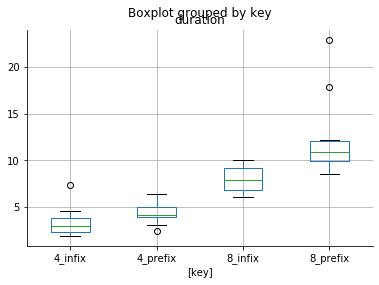

In [383]:
all_df = pd.concat([
    to_df(fourop_prefix_results, '4_prefix'),
    to_df(fourop_infix_results, '4_infix'),
    to_df(eightop_prefix_results, '8_prefix'),
    to_df(eightop_infix_results, '8_infix')
])
all_df.boxplot('duration', by=['key'])
sns.despine()

In [384]:
all_df.groupby('key').mean()

,answer,guess,duration,correct
key,,,,
4_infix,2.882353,2.882353,3.267388,1.0
4_prefix,2.307692,2.307692,4.308865,1.0
8_infix,2.300000,2.200000,7.944593,0.9
8_prefix,3.800000,3.800000,12.472072,1.0
